# WaterNet

For detailed insights, refer to the original source: [Paper](https://arxiv.org/abs/1901.05495) and [Code](https://github.com/tnwei/waternet)

In [4]:
import torch
preprocess, postprocess, model = torch.hub.load('tnwei/waternet:main', 'waternet', trust_repo=True)
model.eval()

Using cache found in /home/joseareia/.cache/torch/hub/tnwei_waternet_main


WaterNet(
  (cmg): ConfidenceMapGenerator(
    (conv1): Conv2d(12, 128, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (relu1): ReLU()
    (conv2): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (relu2): ReLU()
    (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu3): ReLU()
    (conv4): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), padding=same)
    (relu4): ReLU()
    (conv5): Conv2d(64, 64, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (relu5): ReLU()
    (conv6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (relu6): ReLU()
    (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (relu7): ReLU()
    (conv8): Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (sigmoid): Sigmoid()
  )
  (wb_refiner): Refiner(
    (conv1): Conv2d(6, 32, kernel_size=(7, 7), stride=(1, 1), padding=same)
    (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), pad

In [5]:
import glob
imgs = sorted(glob.glob("Dataset/*"))

In [8]:
%%time
import os
import cv2
for rgb_im in imgs:
  im = cv2.imread(rgb_im)
  im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  im = cv2.resize(im, (800, 600))
  rgb_ten, wb_ten, he_ten, gc_ten = preprocess(im)
  out_ten = model(rgb_ten, wb_ten, he_ten, gc_ten)
  out_im = postprocess(out_ten)
  cv2.imwrite("Output_Waternet/"+"out_"+ os.path.basename(rgb_im), cv2.cvtColor(out_im[0], cv2.COLOR_RGB2BGR))    

CPU times: user 3min 30s, sys: 1min 16s, total: 4min 46s
Wall time: 45.8 s


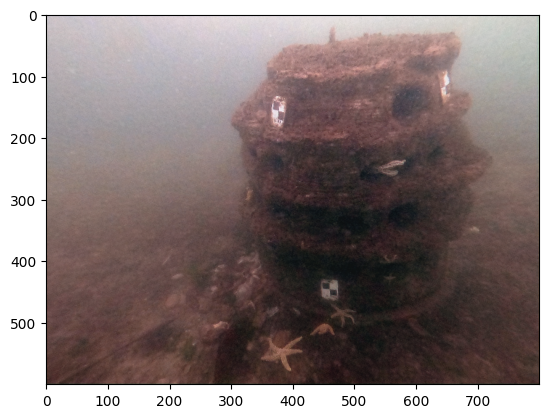

In [9]:
import matplotlib.pyplot as plt
plt.imshow(out_im[0])

## Visualisations of the results

In [11]:
imgs_out = sorted(glob.glob("Output_Waternet/*"))

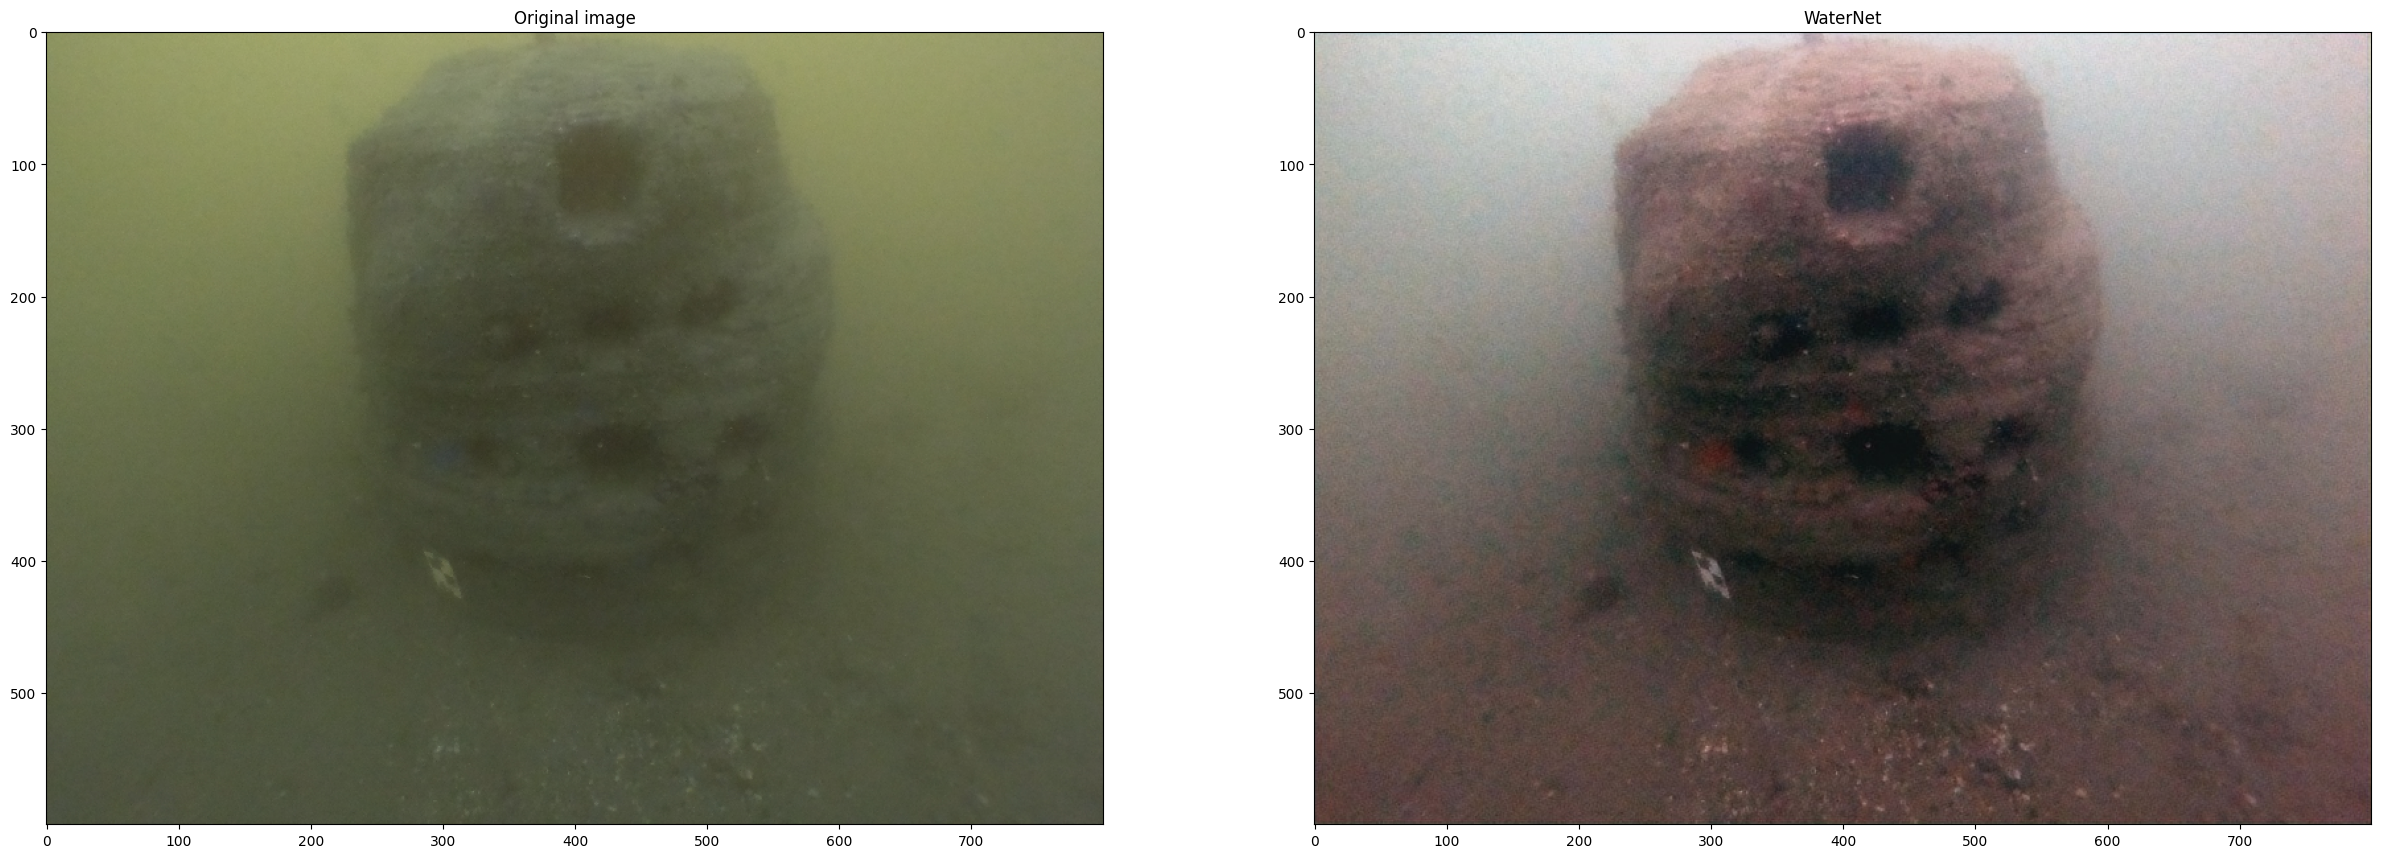

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(30, 30))
im = cv2.imread(imgs[0])
im = cv2.resize(im, (800, 600))

ax[0].imshow(im)
ax[0].set_title("Original image")

out_img = cv2.imread(imgs_out[0])
out_img = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
ax[1].imshow(out_img)
ax[1].set_title("WaterNet")

plt.show()

### Edges Visualization

In [13]:
edg_out = cv2.Canny(out_img,100,200)
edg_in = cv2.Canny(im,100,200)

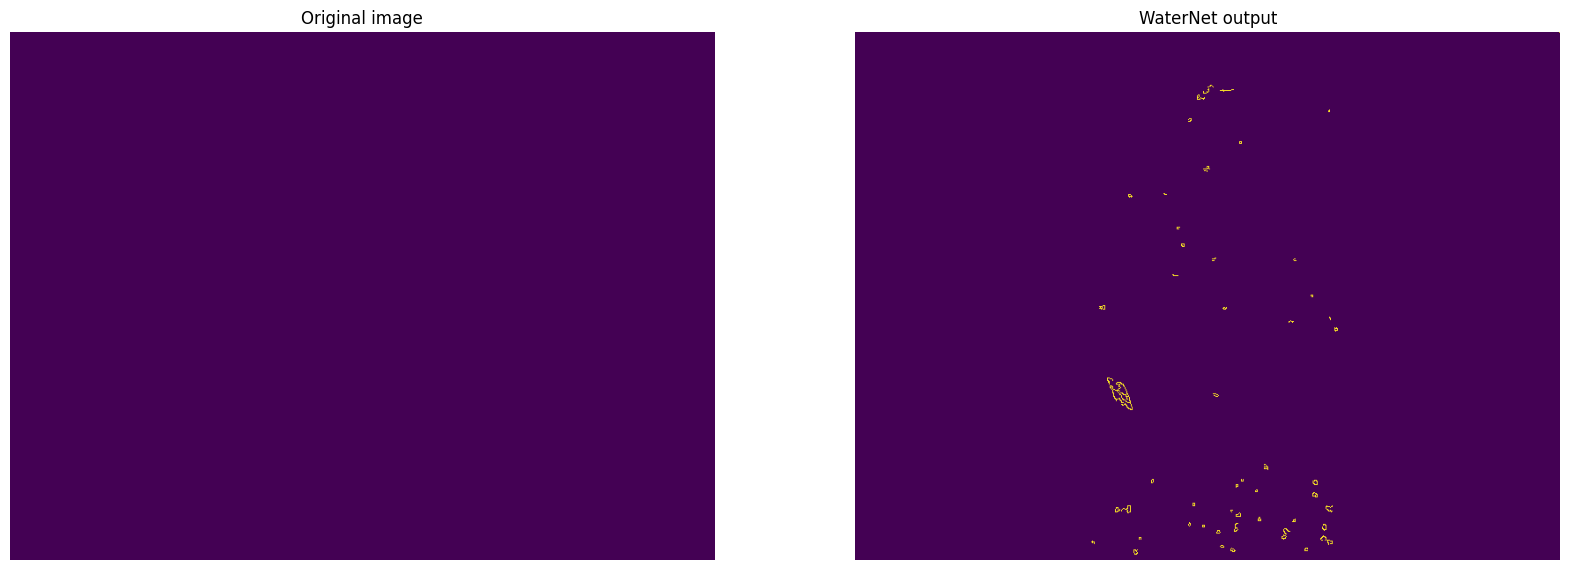

In [14]:
fig, ax = plt.subplots(ncols=2, figsize=(20, 10))
ax[0].imshow(edg_in)
ax[0].axis("off")
ax[0].set_title("Original image")

ax[1].imshow(edg_out)
ax[1].axis("off")
ax[1].set_title("WaterNet output")

plt.show()

## Evalution metrics

Please refer to the [original source](https://github.com/Riccellisp/ProjetoPecem/blob/ba8c5e7b991e93044e3c86c42e48d3df4c9595fb/metrics.py) of the metric.

In [15]:
import sys
import math
import numpy as np
from skimage import color,filters
from skimage.metrics import structural_similarity as ssim

def plipsum(i,j,gamma=1026):
    return i + j - i * j / gamma

def plipsub(i,j,k=1026):
    return k * (i - j) / (k - j)

def plipmult(c,j,gamma=1026):
    return gamma - gamma * (1 - j / gamma)**c

def logamee(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)

    s = 0
    w = 1. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]

            block = ch[xlb:xrb,ylb:yrb]
            blockmin = float(np.min(block))
            blockmax = float(np.max(block))

            top = plipsub(blockmax,blockmin)
            bottom = plipsum(blockmax,blockmin)
            m = bottom and top / bottom or 0
            if m ==0.:
                s+=0
            else:
                s += (m) * np.log(m)

    return plipmult(w,s)

def eme(img,rowSample,columnSample):
	grayImg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	rowSize, columnSize = grayImg.shape
	nRows = int(rowSize/rowSample)
	nColumns = int(columnSize/columnSample)
	incompleteRow = math.ceil(rowSize/rowSample) - nRows
	incompleteColumn = math.ceil(columnSize/columnSample) - nColumns

	somatory = 0
	nBlocks = nRows*nColumns
	for i in range(0,nRows):
		for j in range(0,nColumns):
			imax=grayImg[i*rowSample:(i+1)*rowSample,j*columnSample:(j+1)*rowSample].max()
			imin=grayImg[i*rowSample:(i+1)*rowSample,j*columnSample:(j+1)*rowSample].min()
			if imin==0:
				imin=1
			if imax==0:
				imax=1
			somatory = somatory + 20*math.log(imax/imin)

	if incompleteColumn==1:
		for i in range(0,nRows):
			imax=grayImg[i*rowSample:(i+1)*rowSample,nColumns*columnSample:columnSize].max()
			imin=grayImg[i*rowSample:(i+1)*rowSample,nColumns*columnSample:columnSize].min()
			if imin==0:
				imin=1
			if imax==0:
				imax=1
			somatory = somatory + 20*math.log(imax/imin)
			nBlocks = nBlocks + 1
	if incompleteRow==1:
		for j in range(0,nColumns):
			imax=grayImg[grayImg[nRows*rowSample:rowSize,j*columnSample:(j+1)*columnSample]].max()
			imin=grayImg[grayImg[nRows*rowSample:rowSize,j*columnSample:(j+1)*columnSample]].min()
			if imin==0:
				imin=1
			if imax==0:
				imax=1
			somatory = somatory + 20*math.log(imax/imin)
			nBlocks = nBlocks + 1
	if incompleteRow==1 and incompleteColumn==1:
		imax=grayImg[nRows*rowSample:rowSize,nColumns*columnSample:columnSize].max()
		imin=grayImg[nRows*rowSample:rowSize,nColumns*columnSample:columnSize].max()
		if imin==0:
			imin=1
		if imax==0:
			imax=1
		somatory = somatory + 20*math.log(imax/imin)
		nBlocks = nBlocks + 1
	return somatory/nBlocks

def UCIQE(a,c1=0.4680,c2 = 0.2745,c3 = 0.2576):
    """
    M. Yang and A. Sowmya, "An Underwater Color Image Quality Evaluation Metric" in IEEE Transactions on Image Processing,
    vol. 24, no. 12, pp. 6062-6071, Dec. 2015, doi: 10.1109/TIP.2015.2491020.
    
    The Underwater Colour Image Quality Evaluation Metric (UCIQE) is a metric based on the linear combination of chroma (purity),
    saturation, and contrast, primarily for underwater images but also influenced by recent studies on the evaluation of atmospheric
    colour images.
    """
    rgb = a
    lab = color.rgb2lab(a)
    l = lab[:,:,0]

    chroma = (lab[:,:,1]**2 + lab[:,:,2]**2)**0.5
    uc = np.mean(chroma)
    sc = (np.mean((chroma - uc)**2))**0.5

    top = int(np.round(0.01*l.shape[0]*l.shape[1]))
    sl = np.sort(l,axis=None)
    isl = sl[::-1]
    conl = np.mean(isl[:top])-np.mean(sl[:top])

    satur = []
    chroma1 = chroma.flatten()
    l1 = l.flatten()
    for i in range(len(l1)):
      if chroma1[i] == 0: satur.append(0)
      elif l1[i] == 0: satur.append(0)
      else: satur.append(chroma1[i] / l1[i])

    us = np.mean(satur)

    return  c1 * sc + c2 * conl + c3 * us

def UIQM(a,p1=0.0282,p2=0.2953,p3=3.5753):
    """
    K. Panetta, C. Gao and S. Agaian, Human-Visual-System-Inspired Underwater Image Quality Measures,
    in IEEE Journal of Oceanic Engineering, vol. 41, no. 3, pp. 541-551, July 2016, doi: 10.1109/JOE.2015.2469915.
    
    Similar to UCIQE, but more up-to-date. It takes into account the measure of colouration, sharpness, and contrast.
    """

    rgb = a
    gray = color.rgb2gray(a)
    rg = rgb[:,:,0] - rgb[:,:,1]
    yb = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]
    rgl = np.sort(rg,axis=None)
    ybl = np.sort(yb,axis=None)
    al1 = 0.1
    al2 = 0.1
    T1 = int(al1 * len(rgl))
    T2 = int(al2 * len(rgl))
    rgl_tr = rgl[T1:-T2]
    ybl_tr = ybl[T1:-T2]

    urg = np.mean(rgl_tr) # μ^2_α,RG
    s2rg = np.mean((rgl_tr - urg) ** 2)  # σ2α,RG
    uyb = np.mean(ybl_tr) # μ^2_α,YB
    s2yb = np.mean((ybl_tr- uyb) ** 2) # σ2α,YB

    uicm =-0.0268 * np.sqrt(urg**2 + uyb**2) + 0.1586 * np.sqrt(s2rg + s2yb)

    Reme = eme(a,8,8)
    Geme = eme(a,8,8)
    Beme = eme(a,8,8)
    uism = 0.299 * Reme + 0.587 * Geme + 0.114 * Beme

    uiconm = logamee(gray)
    uiqm = p1 * uicm + p2 * uism + p3 * uiconm

    return uiqm

def CCF(imageRGB):
	"""
    @article{WANG2018904,
    	title = {An imaging-inspired no-reference underwater color image quality assessment metric},
    	journal = {Computers & Electrical Engineering},
    	volume = {70},
    	pages = {904-913},
    	year = {2018},
    	issn = {0045-7906},
    	doi = {https://doi.org/10.1016/j.compeleceng.2017.12.006},
    	url = {https://www.sciencedirect.com/science/article/pii/S0045790617324953},
    	author = {Yan Wang and Na Li and Zongying Li and Zhaorui Gu and Haiyong Zheng and Bing Zheng and Mengnan Sun},
    	keywords = {No-reference image quality assessment, Underwater imaging, Underwater image, Underwater color image quality},
    	abstract = {Underwater color image quality assessment (IQA) plays an important role in analysis and applications of underwater imaging as well as image processing algorithms. This paper presents a new metric inspired by the imaging analysis on underwater absorption and scattering characteristics, dubbed the CCF. This metric is feature-weighted with a combination of colorfulness index, contrast index and fog density index, which can quantify the color loss caused by absorption, the blurring caused by forward scattering and the foggy caused by backward scattering, respectively. Then multiple linear regression is used to calculate three weighted coefficients. A new underwater image database is built to illustrate the performance of the proposed metric. Experimental results show a strong correlation between the proposed metric and mean opinion score (MOS). The proposed CCF metric outperforms many of the leading atmospheric IQA metrics, and it can effectively assess the performance of underwater image enhancement and image restoration methods.}
    }

	This metric is weighted by features using a combination of a colourfulness index, a contrast index, and a fog density index,
    which can quantify colour loss caused by absorption, blurring caused by forward scattering, and fogging caused by backward 
    scattering, respectively.
	"""
	rgb=imageRGB
	gray = color.rgb2gray(imageRGB)
    
	# Passo 1
	Rij=np.log(rgb[:,:,0])-np.mean(rgb[:,:,0])
	Gij=np.log(rgb[:,:,1])-np.mean(rgb[:,:,1])
	Bij=np.log(rgb[:,:,2])-np.mean(rgb[:,:,2])

	# Passo 2
	a = rgb[:,:,0] - rgb[:,:,1]
	b = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]

	var_a  = np.var(a)
	var_b  = np.var(b)
	mean_a = np.mean(a)
	mean_b = np.mean(b)

	ccf=(math.sqrt(var_a+var_b)+0.3*math.sqrt(var_a+var_b)) /85.59

	return ccf

In [16]:
UIQM_list, UCIQE_list, CCF_list  = list(), list(), list()
UIQM_out_list, UCIQE_out_list, CCF_out_list  = list(), list(), list()

for img in imgs:
  im = cv2.imread(img)
  im = cv2.resize(im, (800, 600))
  UIQM_list.append(UIQM(im))
  UCIQE_list.append(UCIQE(im))
  CCF_list.append(CCF(im))

for img in imgs_out:
  im = cv2.imread(img)
  im = cv2.resize(im, (800, 600))
  UIQM_out_list.append(UIQM(im))
  UCIQE_out_list.append(UCIQE(im))
  CCF_out_list.append(CCF(im))

In [17]:
from tabulate import tabulate
data = [
    ["UIQM", np.mean(UIQM_list), np.std(UIQM_list)],
    ["UCIQE", np.mean(UCIQE_list), np.std(UCIQE_list)],
    ["CCF", np.mean(CCF_list), np.std(CCF_list)],
    ["UIQM_WaterNet", np.mean(UIQM_out_list), np.std(UIQM_out_list)],
    ["UCIQE_WaterNet", np.mean(UCIQE_out_list), np.std(UCIQE_out_list)],
    ["CCF_WaterNet", np.mean(CCF_out_list), np.std(CCF_out_list)],
]

headers = ["Metric", "Mean", "Standard Deviation"]
print(tabulate(data, headers=headers, tablefmt="simple_grid", numalign="right"))

┌────────────────┬──────────┬──────────────────────┐
│ Metric         │     Mean │   Standard Deviation │
├────────────────┼──────────┼──────────────────────┤
│ UIQM           │ 0.400654 │             0.156042 │
├────────────────┼──────────┼──────────────────────┤
│ UCIQE          │  16.9709 │              2.73291 │
├────────────────┼──────────┼──────────────────────┤
│ CCF            │ 0.755423 │              0.30076 │
├────────────────┼──────────┼──────────────────────┤
│ UIQM_WaterNet  │  1.85818 │             0.422433 │
├────────────────┼──────────┼──────────────────────┤
│ UCIQE_WaterNet │  25.2543 │             0.518494 │
├────────────────┼──────────┼──────────────────────┤
│ CCF_WaterNet   │  1.95306 │             0.104967 │
└────────────────┴──────────┴──────────────────────┘
